In [1]:
using JOcTree
using MaxwellNatSource
using MaxwellUtils
using MaxwellFrequency
using jInv.LinearSolvers
using jInv.Utils
using PyPlot

mu0 = 4*pi*1e-7;
phase(x) = rad2deg(atan(real(x)./imag(x)))

phase (generic function with 1 method)

## Setup the mesh

In [2]:
nx, ny, nz = 512, 512, 2048
hx, hy, hz = 10., 10., 10.
x0, y0, z0 = -nx*hx/2, -ny*hy/2, -nz*hz/2
c = 40.
xa, xb = -c, c
ya, yb = -c, c
za, zb = -c, c
nf, nc = 1, 1

S = createOcTreeFromBox(x0, y0, z0, nx, ny, nz, hx, hy, hz, xa, xb, ya, yb, za, zb, nf, nc)
msh = getOcTreeMeshFV(S,[hx, hy, hz];x0=[x0, y0, z0])
println("Mesh contains $(msh.nc) cells")
;

Mesh contains 4344 cells


## Setup the model

In [3]:
gcc = getCellCenteredGrid(msh)
sig = 0.01
sigma = 1e-8*ones(msh.nc)
sigma[gcc[:,3].<0.] = sig
;

## Setup forward problem

In [4]:
Srcs = [[0.0 0.0 0.0; 0.0 0.0 0.0]]

omegas = logspace(0,3,5)*2*pi

Recs = Array(Array{Float64},4)
Recs[1] = [-0.5 0. 0.; 
           0.5 0. 0.]
Recs[2] = [0. -0.5 0.;
           0. 0.5 0.]
Recs[3] = [0.0  -0.5  -0.5;
           0.0  -0.5   0.5;
           0.0   0.5   0.5;
           0.0   0.5  -0.5;
           0.0  -0.5  -0.5]
Recs[4] = [-0.5  0.0  -0.5;
           -0.5  0.0   0.5;
            0.5  0.0   0.5;
            0.5  0.0  -0.5;
           -0.5  0.0  -0.5]

Dobs = [complex(0,0)]
Wd = [complex(0,0)]

trx = Array(TransmitterOmega, length(omegas))
for (i, w) in enumerate(omegas)
    trx[i] = TransmitterOmega( Srcs, w, Recs, Dobs, Wd )
end

Obs = getAllObs( trx, msh );

linSolParam = getMUMPSsolver([],1,0,2);

Sources = Array(Complex128, 0, 0)
fields = Array(Complex128, 0, 0)
pFor = Array(MaxwellFreqParam, length(trx))
for i in 1:length(trx)
    pFor[i] = getMaxwellFreqParam(msh, Sources, Obs[i], fields, trx[i].omega, linSolParam);
end
;

## Run the forward problem

In [5]:
for i in 1:length(trx)
    pFor[i] = calcMTSources( sigma, pFor[i], true );
end

In [6]:
DDs = Array(Array{Complex{Float64}}, length(trx))
zdpreds = Array(Array{Complex{Float64}}, length(trx))
for i in 1:length(trx)
    DDs[i], pFor[i] = getData( sigma, pFor[i], true );
    zdpreds[i] = calcMTdata(DDs[i]);
end

# Results

In [7]:
Zc = zeros(Complex128, length(trx))
for i in 1:length(trx)
    Zc[i] = zdpreds[i][1,2,1]
end

Z = zeros(Complex128, length(trx))
for i in 1:length(trx)
    k = sqrt(-im*trx[i].omega*mu0*sig)
    Z[i] = mu0*im*trx[i].omega/k
end


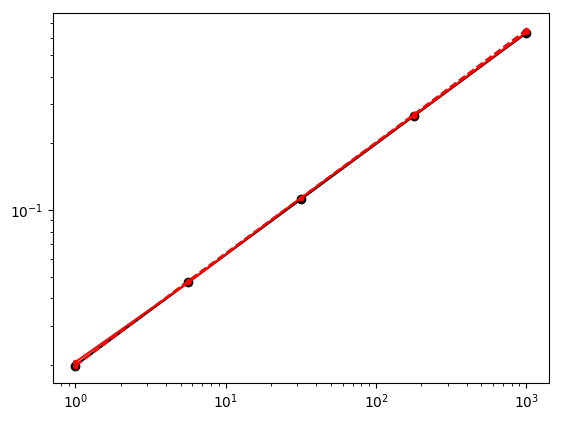

In [8]:
clf()
loglog(omegas./(2*pi), abs(real(Z)),"-ko")
loglog(omegas./(2*pi), abs(real(Zc)),"-r.")
loglog(omegas./(2*pi), abs(imag(Zc)),"--r.")
show()

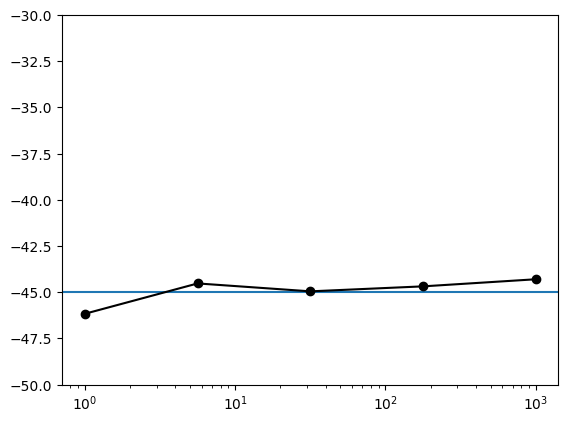

In [9]:
axhline(-45)
semilogx(omegas./(2*pi), phase(Zc), "-ko")
ylim(-50, -30)
show()